In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.datasets import load_iris

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import OneHotEncoder

class MLP:
    def __init__(self, input_dim, hidden_layer_dims, output_layer_dim, learning_rate=0.01, error_threshold=0.01, max_iter=1000):
        """
        Initializes the MLP model for multi-class classification.
        """
        self.input_dim = input_dim
        self.hidden_layer_dims = hidden_layer_dims
        self.output_layer_dim = output_layer_dim
        self.learning_rate = learning_rate
        self.error_threshold = error_threshold
        self.max_iter = max_iter

        # Initialize weights and biases
        self.weights = [np.random.randn(prev_layer, next_layer) / np.sqrt(prev_layer / 2.) for prev_layer, next_layer in zip([input_dim] + hidden_layer_dims, hidden_layer_dims + [output_layer_dim])]
        self.biases = [np.zeros((1, size)) for size in hidden_layer_dims + [output_layer_dim]]
        self.losses = []
        self.gradient_magnitudes = []

    @staticmethod
    def _softmax(x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)

    @staticmethod
    def _tanh(x):
        return np.tanh(x)

    @staticmethod
    def _tanh_derivative(x):
        return 1 - np.power(x, 2)

    def _forward_propagation(self, x):
        activations = [x]
        for weight, bias in zip(self.weights[:-1], self.biases[:-1]):  # Hidden layers
            z = np.dot(activations[-1], weight) + bias
            a = self._tanh(z)
            activations.append(a)
        # Output layer
        z = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        a = self._softmax(z)
        activations.append(a)
        return activations

    def _backward_propagation(self, activations, y):
        layer_errors = [activations[-1] - y]  # Output layer error
        # Propagate errors backwards
        for i in reversed(range(len(self.weights)-1)):
            layer_errors.insert(0, np.dot(layer_errors[0], self.weights[i+1].T) * self._tanh_derivative(activations[i+1]))
        # Update weights and biases
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * np.dot(activations[i].T, layer_errors[i])
            self.biases[i] -= self.learning_rate * np.sum(layer_errors[i], axis=0, keepdims=True)

    def fit(self, X, y):
        # Convert labels to one-hot encoding
        encoder = OneHotEncoder(sparse=False, categories='auto')
        y_one_hot = encoder.fit_transform(y.reshape(-1, 1))
        
        for epoch in range(self.max_iter):
            activations = self._forward_propagation(X)
            self._backward_propagation(activations, y_one_hot)
            
            loss = -np.mean(np.log(activations[-1]) * y_one_hot)
            self.losses.append(loss)
            
            if loss < self.error_threshold:
                print(f"Training stopped at epoch {epoch} due to reaching error threshold.")
                break
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss}")

    def predict(self, X):
        # Only for the forward pass to get output
        last_activation = self._forward_propagation(X)[-1]
        # Return class labels
        return np.argmax(last_activation, axis=1)

    # Visualization and other utility methods like plot_loss, plot_weight_histograms etc., remain the same


    def plot_loss(self):
        plt.plot(self.losses, label='Training Loss')
        plt.title('Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    
    def predict(self, X):
        probabilities = self._forward_propagation(X)[-1]
        return np.argmax(probabilities, axis=1)
    
    @staticmethod
    def mean_squared_error(y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)
    
    def display(self):
        '''
        Display a visualization of the neural network architecture with colored nodes and lines.
        '''
        def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
            # Define colors for different layers
            input_color = 'lightblue'
            hidden_color = 'lightgreen'
            output_color = 'salmon'
            line_color = 'gray'  # Color for connections
            
            v_spacing = (top - bottom) / float(max(layer_sizes))
            h_spacing = (right - left) / float(len(layer_sizes) - 1)
            
            # Nodes
            for n, layer_size in enumerate(layer_sizes):
                layer_color = hidden_color if n > 0 and n < len(layer_sizes) - 1 else (input_color if n == 0 else output_color)
                layer_top = v_spacing * (layer_size - 1) / 2. + (top + bottom) / 2.
                for m in range(layer_size):
                    circle = plt.Circle((n * h_spacing + left, layer_top - m * v_spacing), v_spacing / 4.,
                                        color=layer_color, ec='k', zorder=4)
                    ax.add_artist(circle)
            
            # Edges
            for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
                layer_top_a = v_spacing * (layer_size_a - 1) / 2. + (top + bottom) / 2.
                layer_top_b = v_spacing * (layer_size_b - 1) / 2. + (top + bottom) / 2.
                for m in range(layer_size_a):
                    for o in range(layer_size_b):
                        line = plt.Line2D([n * h_spacing + left, (n + 1) * h_spacing + left],
                                          [layer_top_a - m * v_spacing, layer_top_b - o * v_spacing], c=line_color, alpha=0.5)
                        ax.add_artist(line)
        
        fig = plt.figure(figsize=(12, 12))
        ax = fig.gca()
        ax.axis('off')
        layer_sizes = [self.input_dim] + self.hidden_layer_dims + [self.output_layer_dim]
        draw_neural_net(ax, .1, .9, .1, .9, layer_sizes)
        plt.show()
    
    def display_with_weight(self):
        def draw_neural_net(ax, layer_sizes, weights=None, biases=None):
            left, right, bottom, top = .1, .9, .1, .9
            v_spacing = (top - bottom) / max(layer_sizes)
            h_spacing = (right - left) / (len(layer_sizes) - 1)

            # Nodes and Biases
            for n, neurons in enumerate(layer_sizes):
                layer_top = v_spacing*(neurons-1)/2. + (top + bottom)/2.
                for m in range(neurons):
                    circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                        color='w', ec='k', zorder=4)
                    ax.add_artist(circle)
                    if biases and n < len(biases):
                        bias_val = biases[n][m] if m < len(biases[n]) else 0
                        ax.text(n*h_spacing + left, layer_top - m*v_spacing - v_spacing/8.,
                                f'Bias:\n{bias_val:.2f}', ha='center', va='center', fontsize=6)

            # Edges and Weights
            for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
                layer_top_a = v_spacing*(layer_size_a-1)/2. + (top + bottom)/2.
                layer_top_b = v_spacing*(layer_size_b-1)/2. + (top + bottom)/2.
                for m in range(layer_size_a):
                    for o in range(layer_size_b):
                        line_color = 'blue' if weights[n][m, o] > 0 else 'red'
                        alpha = min(1, abs(weights[n][m, o]) / max(1, np.max(np.abs(weights[n]))))
                        line = plt.Line2D([n*h_spacing + left, (n+1)*h_spacing + left],
                                        [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing],
                                        c=line_color, alpha=alpha, linewidth=2)
                        ax.add_artist(line)
                        if weights and n < len(weights):
                            weight_val = weights[n][m, o]
                            # Optional: Customize the formatting and position of the weight text annotation as needed
                            ax.text((n*h_spacing + (n+1)*h_spacing + left) / 2,
                                    (layer_top_a - m*v_spacing + layer_top_b - o*v_spacing) / 2,
                                    f'{weight_val:.2f}', ha='center', va='center', fontsize=6)


        fig, ax = plt.subplots(figsize=(12, 12))
        ax.axis('off')
        layer_sizes = [self.input_dim] + self.hidden_layer_dims + [self.output_layer_dim]
        weights = [w for w in self.weights]
        biases = [b.ravel() for b in self.biases]  # Flatten biases
        draw_neural_net(ax, layer_sizes, weights, biases)
        plt.show()
    
    def visualize_activations_tsne(self, X, perplexity=30, n_iter=1000):
        # Forward pass through the network to get activations
        activations = self._forward_propagation(X)[-2]  # Get second-to-last layer activations

        # Use t-SNE to project activations to a 2D space
        tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter)
        tsne_results = tsne.fit_transform(activations)

        # Plot the result of t-SNE
        plt.figure(figsize=(10, 8))
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
        plt.title('t-SNE visualization of the first hidden layer activations')
        plt.xlabel('t-SNE feature 1')
        plt.ylabel('t-SNE feature 2')
        plt.show()
    
    def plot_gradient_flow(self):
        # Average the gradient magnitudes across layers for each epoch
        avg_grads = [np.mean(epoch_grads) for epoch_grads in self.gradient_magnitudes]
        plt.figure(figsize=(8, 6))
        plt.plot(avg_grads)
        plt.title('Average Gradient Magnitude Flow Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Average Gradient Magnitude')
        plt.yscale('log')
        plt.show()
        
    def plot_weight_histograms(self):
        # Plot histograms of the weight values for each layer
        for i, w in enumerate(self.weights):
            plt.figure(figsize=(6, 4))
            plt.hist(w.ravel(), bins=50)
            plt.title(f'Layer {i+1} Weight Distribution')
            plt.xlabel('Weight Values')
            plt.ylabel('Frequency')
            plt.show()
            
    def plot_precision_recall_curve(self, X, y):
        # Get the probability scores using the predict method
        probabilities = self._forward_propagation(X)[-1]
        # For each class, calculate precision and recall
        plt.figure(figsize=(8, 6))
        for i in range(probabilities.shape[1]):
            precision, recall, _ = precision_recall_curve((y == i).astype(int), probabilities[:, i])
            plt.plot(recall, precision, marker='.', label=f'Class {i}')
        plt.title('Precision-Recall Curve by Class')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.show()

In [21]:
# Load the Iris dataset
iris = datasets.load_iris()

# Convert the dataset to a DataFrame for easier analysis
iris_df = pd.DataFrame(data=np.c_[iris['data'], iris['target']], columns=iris['feature_names'] + ['target'])

# Display the first few rows of the dataset
iris_df.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


# Data Overview
Let's start by taking a quick look at the structure of the dataset. The Iris dataset contains four features (sepal length, sepal width, petal length, and petal width) and a target variable representing three different species of iris flowers.

In [22]:
# Display basic information about the dataset
iris_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB


# Statistical Summary
Next, let's explore the statistical summary of the dataset to understand the central tendency and dispersion of the features.

In [23]:
# Display the statistical summary of the dataset
iris_df.describe()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


# Data Visualization
Now, let's create visualizations to better understand the relationships between different features and the target variable.

## Pairplot
A pairplot is a great way to visualize the relationships between all pairs of features in the dataset.
This pairplot will display scatterplots for each pair of features, with different colors representing different iris species.

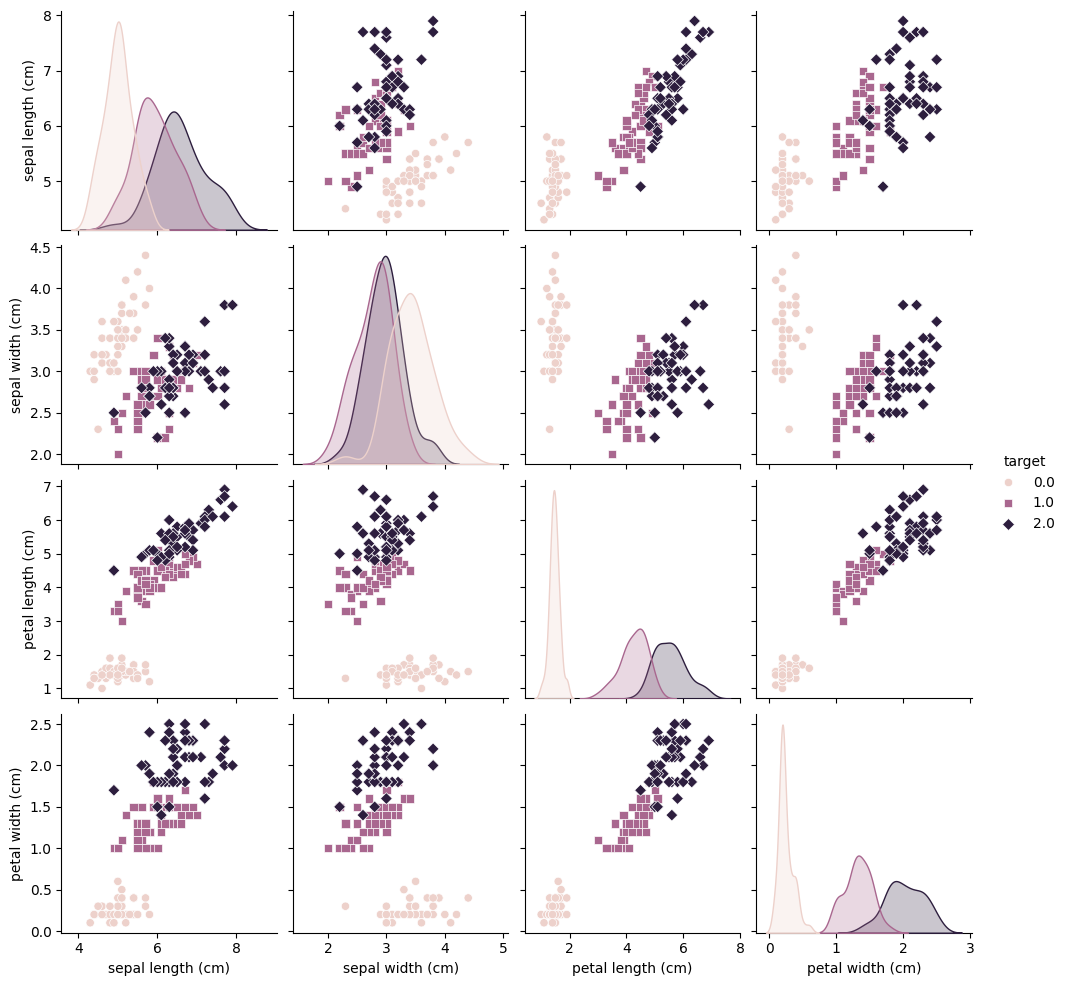

In [24]:
# Pairplot for feature visualization
sns.pairplot(iris_df, hue='target', markers=['o', 's', 'D'])
plt.show()


## Boxplot
Boxplots are useful for visualizing the distribution of each feature. These boxplots will show the distribution of each feature for each iris species, helping to identify any outliers.

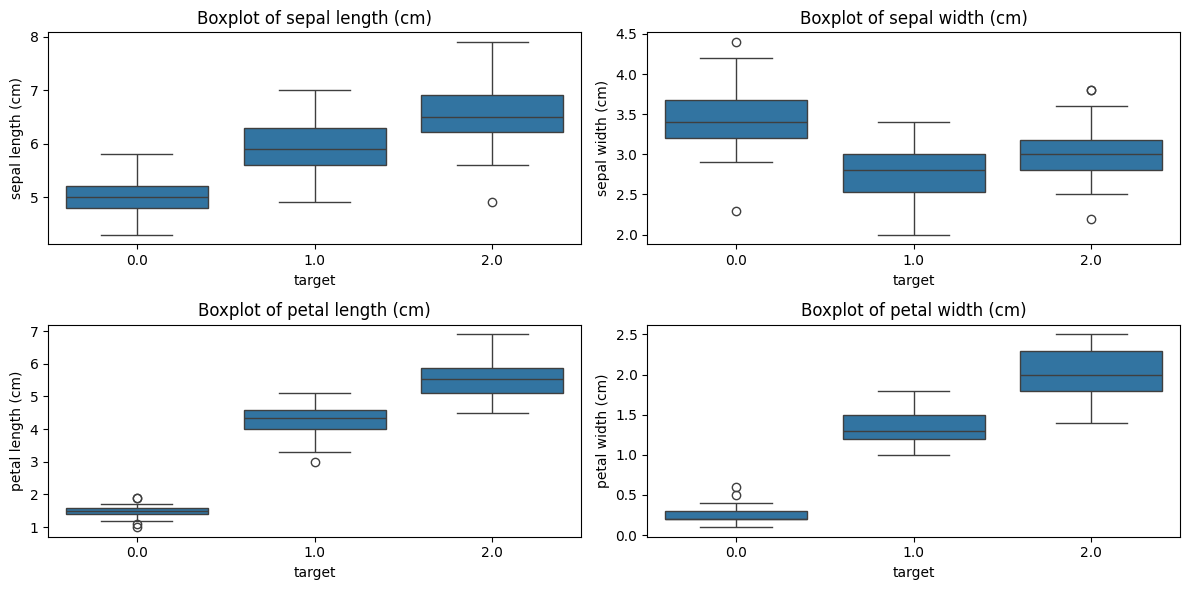

In [25]:
# Boxplot for feature distribution
plt.figure(figsize=(12, 6))
for i, feature in enumerate(iris['feature_names']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='target', y=feature, data=iris_df)
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()


# Correlation heatmap
A correlation heatmap will visualize the correlation between features. This heatmap will display the correlation coefficients between different features, helping us understand which features are more strongly correlated.

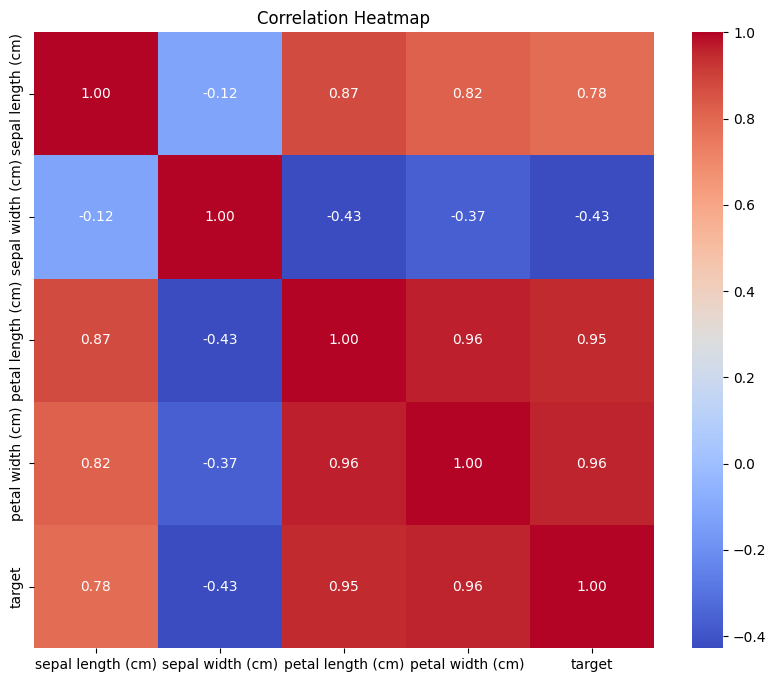

In [26]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(iris_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


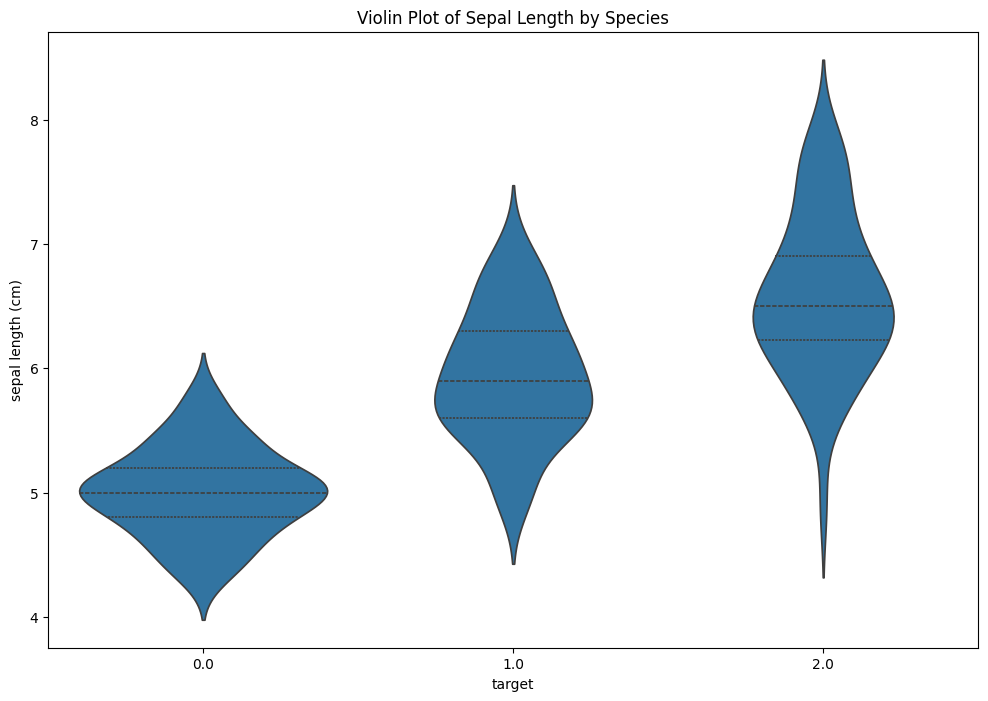

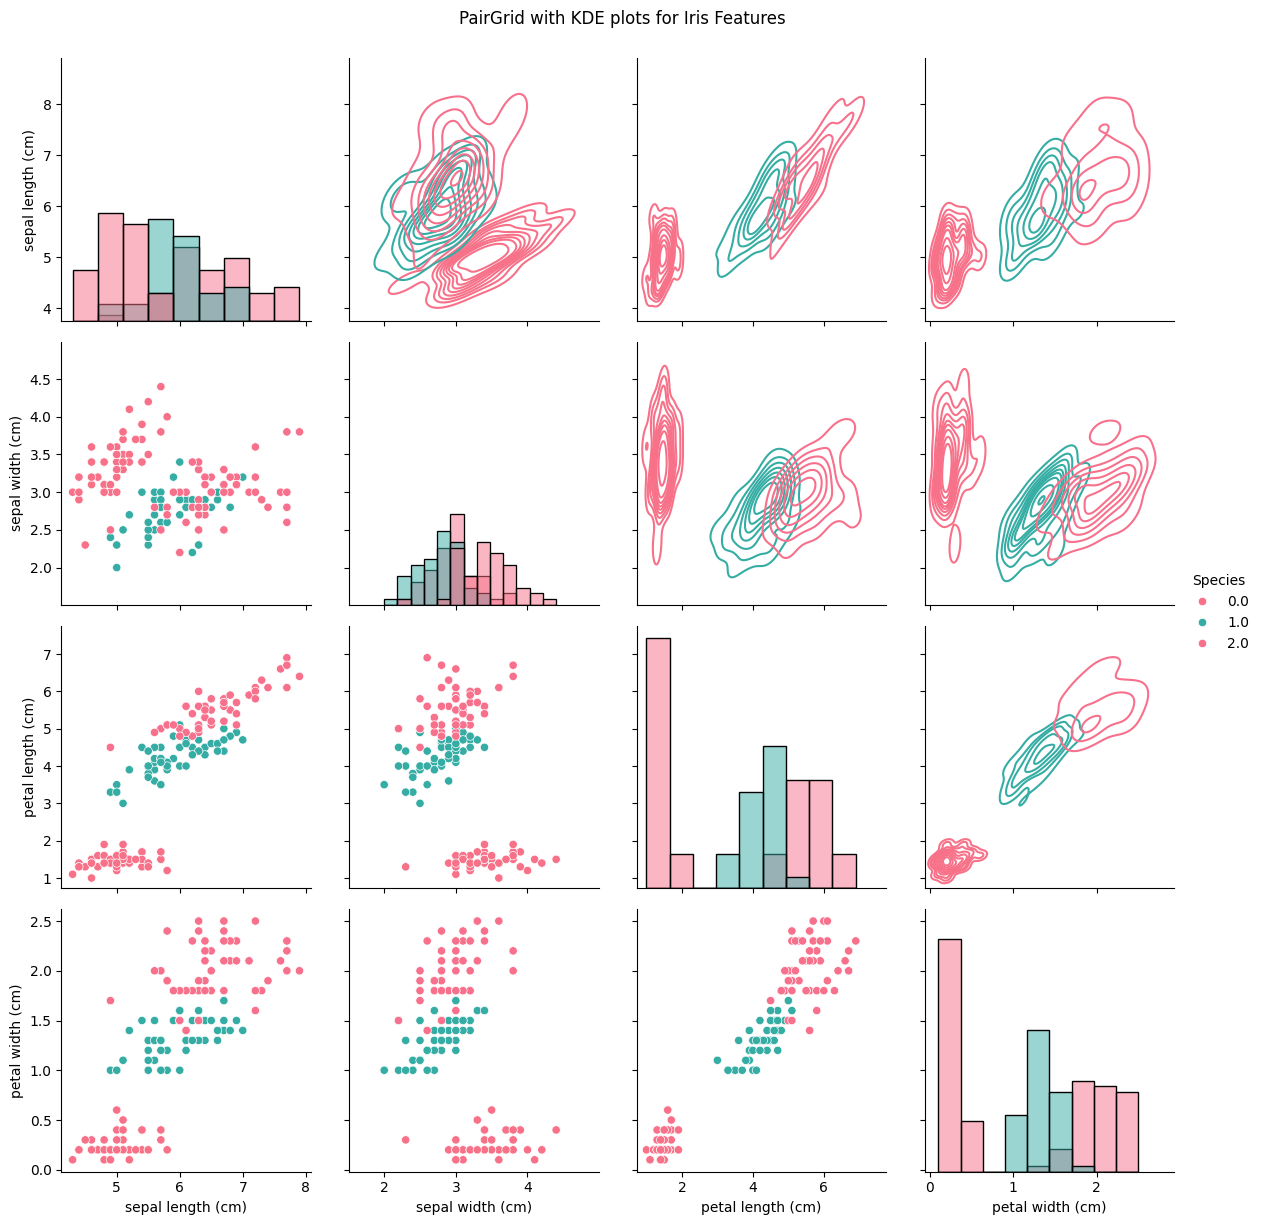

In [27]:
# Load the Iris dataset
iris = datasets.load_iris()

# Convert the dataset to a DataFrame for easier analysis
iris_df = pd.DataFrame(data=np.c_[iris['data'], iris['target']], columns=iris['feature_names'] + ['target'])

# Pairplot with Scatter Matrix using Plotly Express
fig = px.scatter_matrix(iris_df, dimensions=iris['feature_names'], color='target', height=800, width=800)
fig.update_layout(title='Pairplot with Scatter Matrix', font=dict(size=12))
fig.show()

# Violin Plot for feature distribution
plt.figure(figsize=(12, 8))
sns.violinplot(x='target', y='sepal length (cm)', data=iris_df, inner='quartile')
plt.title('Violin Plot of Sepal Length by Species')
plt.show()

# 3D Scatter Plot using Plotly Express
fig = px.scatter_3d(iris_df, x='sepal length (cm)', y='sepal width (cm)', z='petal length (cm)', color='target',
                    symbol='target', size_max=10, opacity=0.8)
fig.update_layout(title='3D Scatter Plot of Sepal and Petal Dimensions', scene=dict(zaxis=dict(title='Petal Length')))
fig.show()

# PairGrid with KDE plots using Seaborn
g = sns.PairGrid(iris_df, hue='target', palette='husl', height=3)
g.map_upper(sns.kdeplot)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.add_legend(title='Species')
plt.suptitle('PairGrid with KDE plots for Iris Features', y=1.02)
plt.show()



In [28]:

# Load the Iris dataset
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target
iris_df['species'] = iris_df['target'].apply(lambda x: iris.target_names[x])

# Calculate mean values for each species
iris_mean = iris_df.groupby('species').mean().reset_index()

# Define categories (feature names)
categories = iris.feature_names

# Preparing theta: Repeat each category name for each species
theta = categories * len(iris_mean)

# Preparing r: Flatten the mean values for each feature across each species, in the correct order
r_values = []
for species in iris_mean['species']:
    species_means = iris_mean[iris_mean['species'] == species][categories].values.flatten()
    r_values.extend(species_means)

# Ensure the color argument matches the length of the data
colors = iris_mean['species'].repeat(len(categories))

# Create the radar chart
fig = px.line_polar(r=r_values, theta=theta, line_close=True,
                    color=colors,
                    template="plotly", direction="clockwise")

# Update the layout to add a title and adjust other aesthetics as needed
fig.update_layout(title='Radar Chart for Feature Comparison by Species')

# Show the plot
fig.show()


## Data Preprocessing
Finally, let's perform any necessary preprocessing steps, such as handling missing values, scaling, or encoding categorical variables.

In [30]:
# Check for missing values
iris_df.isnull().sum()




sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
species              0
dtype: int64

/home/recognise/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



Epoch 0, Loss: 0.3828637351410293
Epoch 100, Loss: 0.018818507636782552
Epoch 200, Loss: 0.01663352884600172
Epoch 300, Loss: 0.016090551488967195
Epoch 400, Loss: 0.01582156466412367
Model accuracy: 1.00


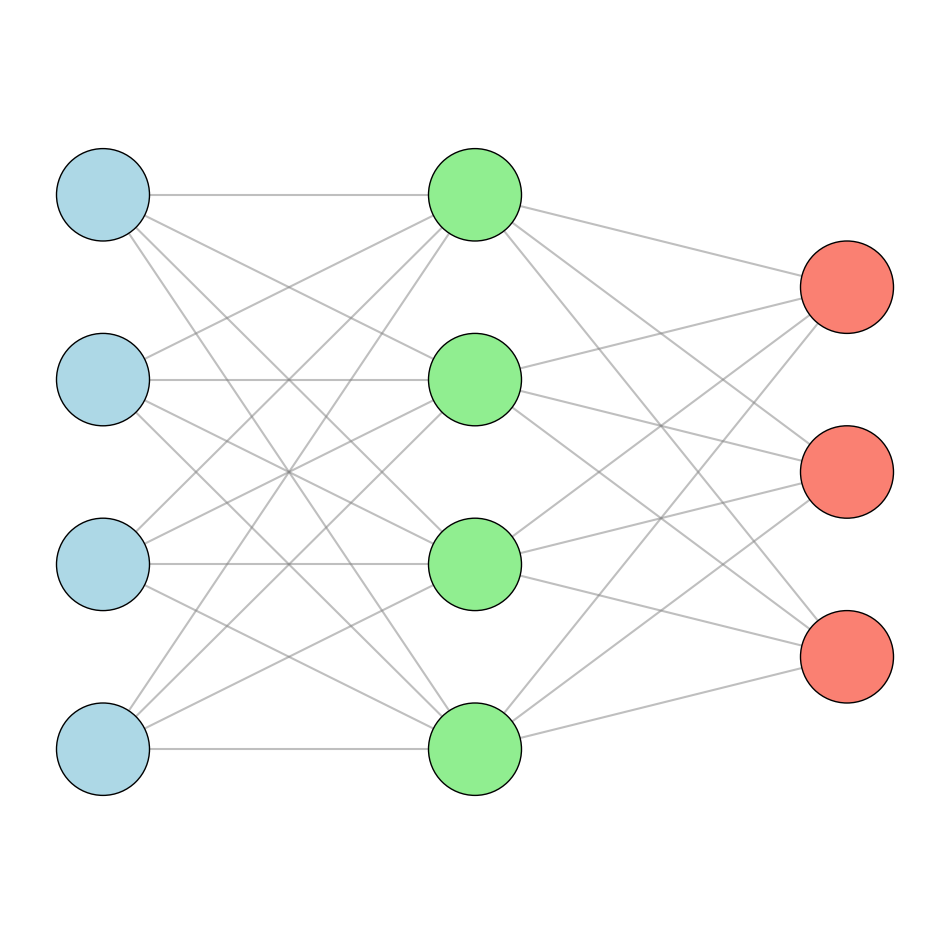

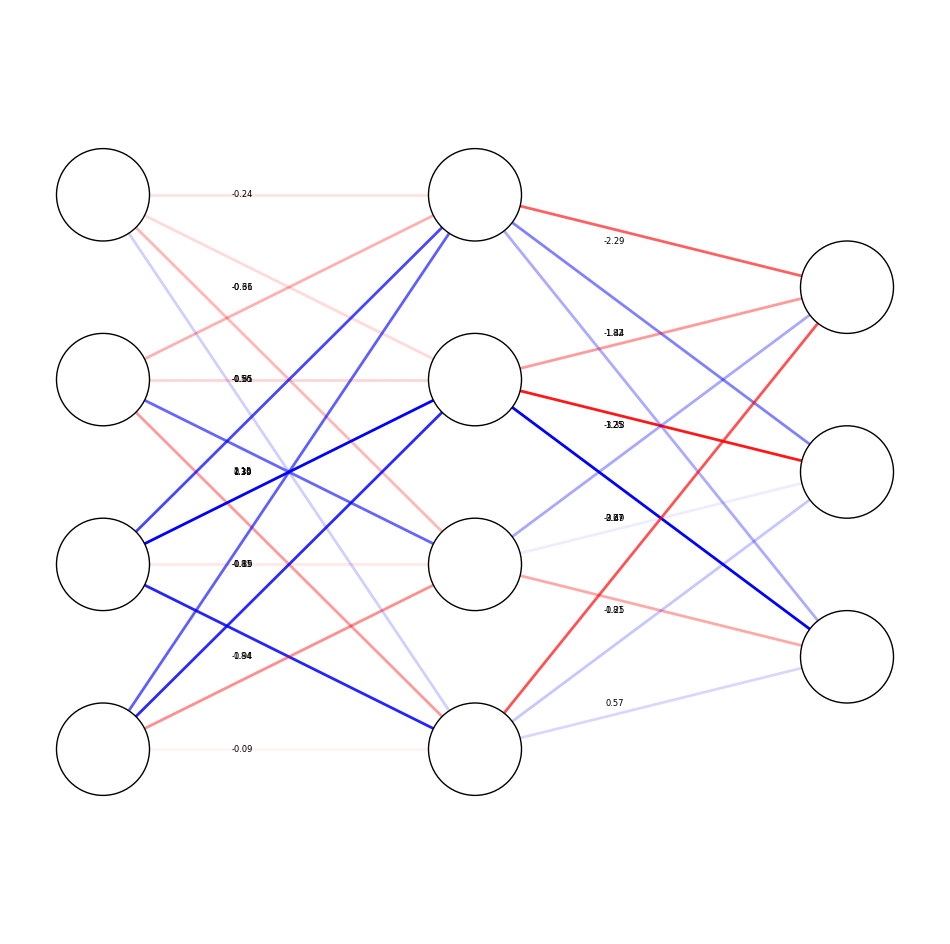

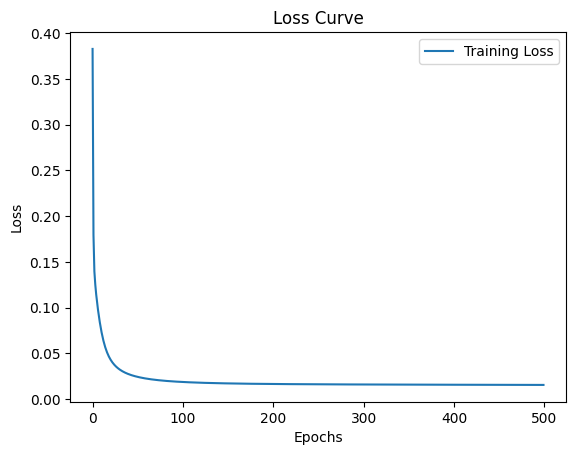

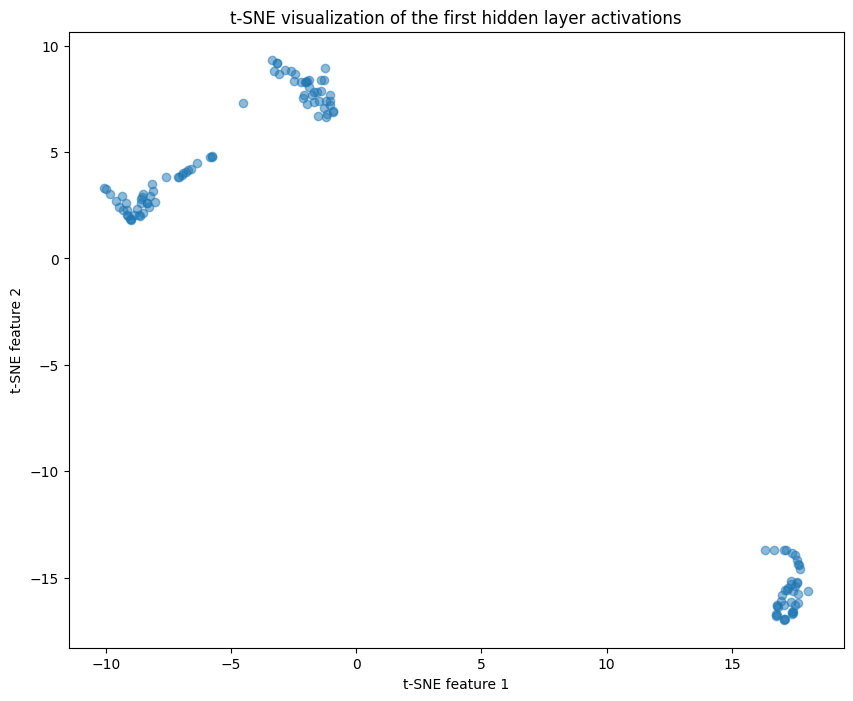

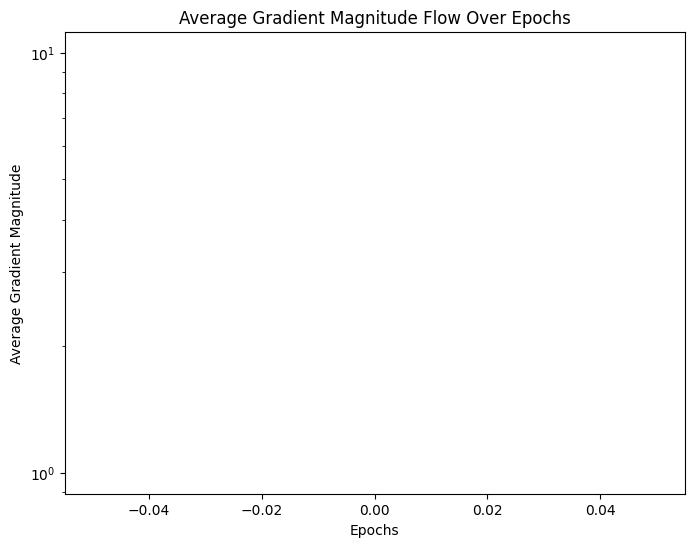

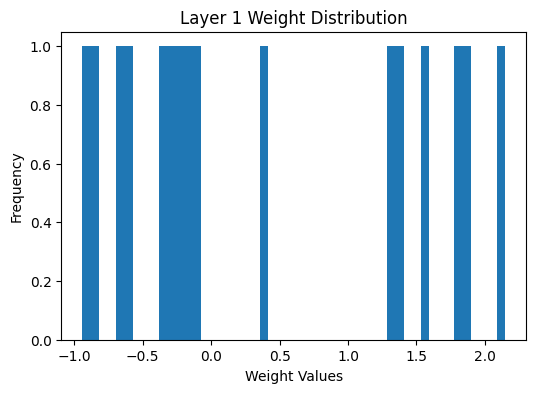

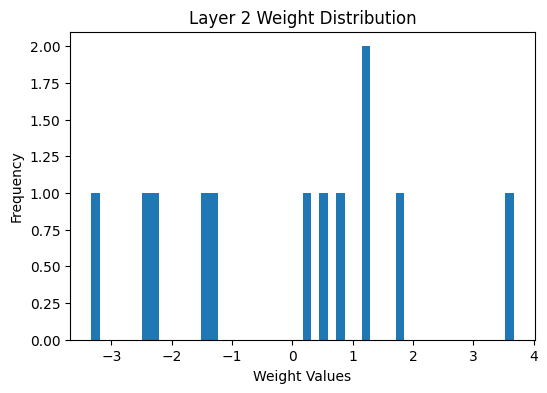

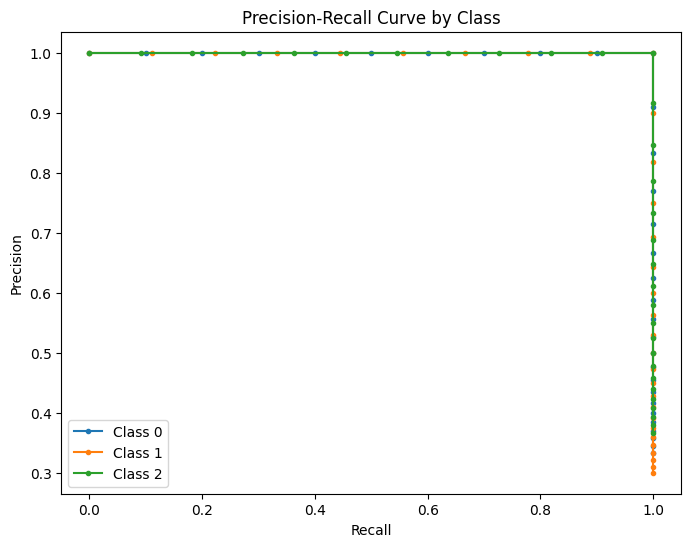

In [31]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neural_network import MLPClassifier  # Using MLPClassifier for this example
import seaborn as sns
import matplotlib.pyplot as plt

# Load the Iris dataset
iris = datasets.load_iris()
X, y = iris.data, iris.target

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
mlp = MLP(input_dim=4, hidden_layer_dims=[4], output_layer_dim=3, learning_rate=0.01, error_threshold=0.01, max_iter=500)
mlp.fit(X_train, y_train)  # Directly use y_train without reshaping to (n_samples, 1)

# Predict on the test set and evaluate the model
predictions = mlp.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f'Model accuracy: {accuracy:.2f}')


mlp.display()
mlp.display_with_weight()
mlp.plot_loss()
mlp.visualize_activations_tsne(X_train)
mlp.plot_gradient_flow()
mlp.plot_weight_histograms()
mlp.plot_precision_recall_curve(X_test, y_test)



/tmp/ipykernel_46895/1442765852.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




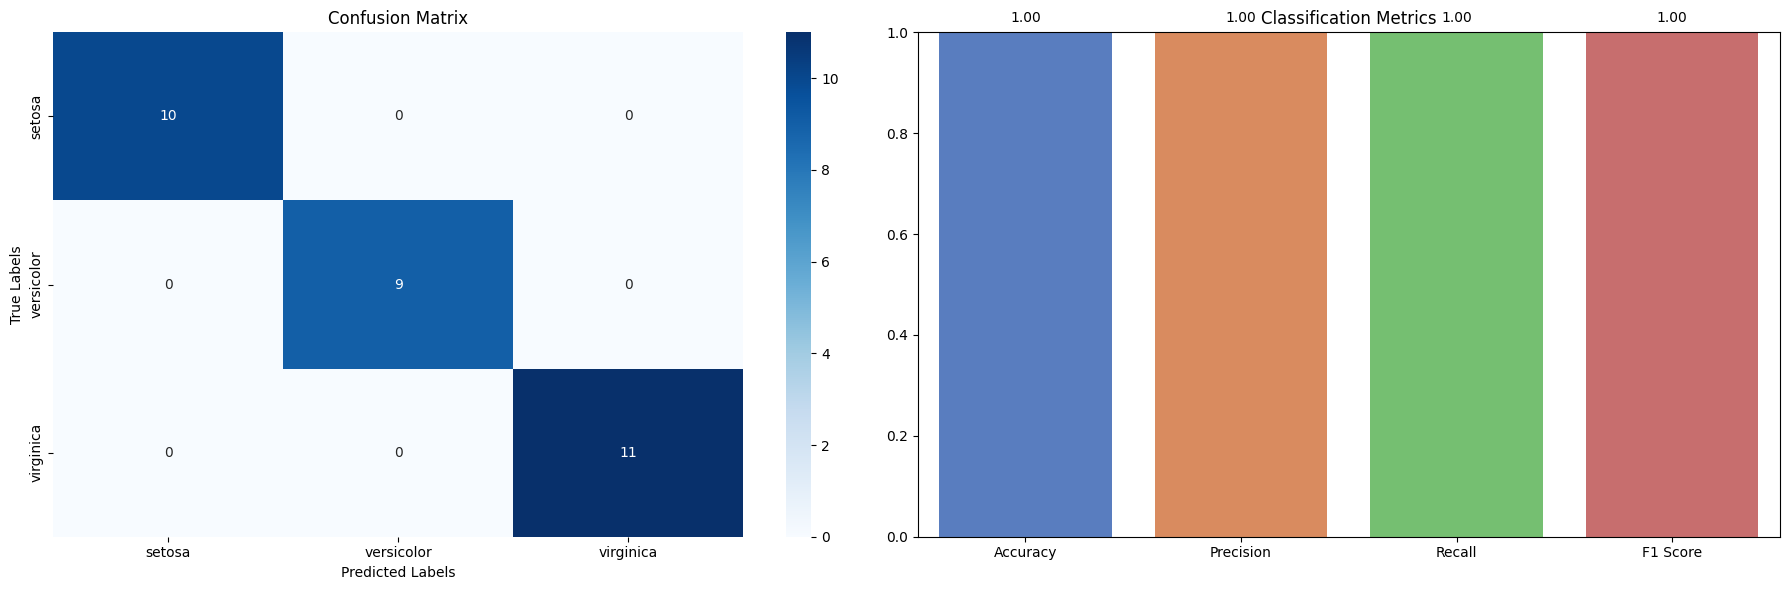

In [32]:

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')
conf_matrix = confusion_matrix(y_test, predictions)

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Confusion Matrix Heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')
ax[0].xaxis.set_ticklabels(iris.target_names)
ax[0].yaxis.set_ticklabels(iris.target_names)

# Metrics Bar Plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]
sns.barplot(x=metrics, y=values, palette='muted', ax=ax[1])
ax[1].set_title('Classification Metrics')
ax[1].set_ylim(0, 1)
for i, value in enumerate(values):
    ax[1].text(i, value + 0.02, f'{value:.2f}', ha='center')

# Show the plot
plt.tight_layout()
plt.show()
